In [57]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [127]:
plt.style.use('seaborn-deep')

In [81]:
#### Pegamos os dados de treino e teste que preparamos anteriormente:

In [82]:
df_train = pd.read_csv('ready_to_train.csv')
df_test = pd.read_csv('ready_to_test.csv')

In [83]:
df_train.head()

,Unnamed: 0,user_id,Unnamed: 0.1,num_hashtags,num_urls,num_mentions,is_reply,hahahaha,http,game,...,yeah,fuck,unfollow,haha,para,lmao,nigga,hahaha,cute,ans
0,0,755116,103224.500000,0.039987,0.120921,0.968650,0.526232,0.00064,0.227767,0.009277,...,0.027511,0.181382,0.000000,0.004159,0.000000,0.0,0.000000,0.002559,0.000320,0.0
1,1,755746,106401.500000,0.270136,0.462515,0.680607,0.347274,0.00000,0.406444,0.001859,...,0.012701,0.000620,0.000000,0.002478,0.007125,0.0,0.000000,0.000620,0.003717,0.0
2,2,785080,109608.000000,0.051491,0.064364,0.786185,0.433281,0.00000,0.095133,0.008163,...,0.021664,0.021350,0.000942,0.000628,0.000000,0.0,0.000314,0.000314,0.001256,0.0
3,3,806585,112772.000000,0.086542,0.102768,1.204582,0.762011,0.00000,0.118676,0.001591,...,0.003500,0.004454,0.001591,0.000000,0.000636,0.0,0.000000,0.000318,0.000955,0.0
4,4,806975,115944.400501,0.202131,0.359762,0.827954,0.348480,0.00000,0.413977,0.010655,...,0.001567,0.001567,0.001567,0.000000,0.003761,0.0,0.000000,0.000000,0.000000,0.0


In [84]:
#### Removemos colunas que atrapalhariam a predição:

In [85]:
df_train.drop(['Unnamed: 0', 'Unnamed: 0.1', 'user_id', 'num_urls'], axis=1, inplace=True)
df_test.drop(['Unnamed: 0', 'Unnamed: 0.1', 'user_id', 'num_urls', 'lang'], axis=1, inplace=True)

In [86]:
#### Separamos em X e y:

In [87]:
X_train = df_train.drop('ans', axis=1)
y_train = df_train['ans']
X_test = df_test.drop('ans', axis=1)
y_test = df_test['ans']

In [88]:
#### Analisamos quais features possuem maior correlação com a classificação de ser bot ou não:

In [89]:
train_cor = X_train.corrwith(y_train)
strong_feats = train_cor[train_cor.abs() > 0.4]

Text(0.5, 1.0, 'Most related features')

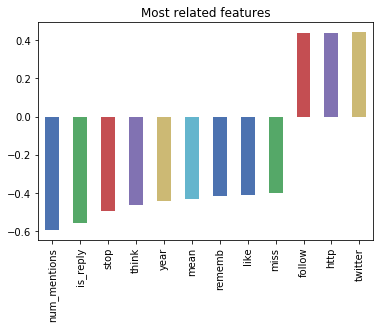

In [128]:
ax = strong_feats.sort_values().plot.bar()
ax.set_title('Most related features')

In [91]:
# Temos que as características num_mentions, que é a média de menções em todos os tweets do usuário, e is_reply, que é a média de seus tweets que são repostas a outros tweets, são as mais relacionadas com o usuário ser ou não um bot.abs
# As palavras mais fortemente relacionadas com ser bot ou não são: twitter, http, follow, stop, think, year, mean, remenb, like e miss

In [92]:
# Modelo de Regressão logística

In [93]:
#### Treinamos uma regressão logística com todas as features:

In [94]:
logistic_reg_model = LogisticRegression(max_iter=100000).fit(X_train, y_train)

In [95]:
print("Logistic Regression train acc: ", logistic_reg_model.score(X_train, y_train))
print("Logistic Regression train prec: ", metrics.precision_score(y_train, logistic_reg_model.predict(X_train)))
print("Logistic Regression train recall: ", metrics.recall_score(y_train, logistic_reg_model.predict(X_train)))
print("")
print("Logistic Regression test acc: ", logistic_reg_model.score(X_test, y_test))
print("Logistic Regression test prec: ", metrics.precision_score(y_test, logistic_reg_model.predict(X_test)))
print("Logistic Regression test recall: ", metrics.recall_score(y_test, logistic_reg_model.predict(X_test)))

Logistic Regression train acc:  0.962086745526236
Logistic Regression train prec:  0.9457917261055635
Logistic Regression train recall:  0.884

Logistic Regression test acc:  0.8512773722627737
Logistic Regression test prec:  0.9574468085106383
Logistic Regression test recall:  0.3614457831325301


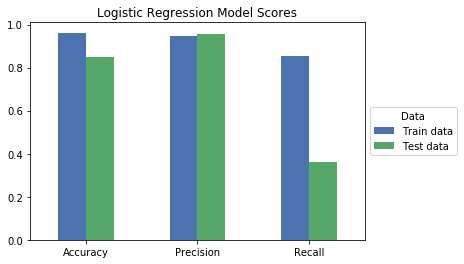

In [129]:
logreg_metrics_dic = {'Metric': ['Acc', 'Prec', 'Recall'],
        'Train data': [logistic_reg_model.score(X_train, y_train),
                    metrics.precision_score(y_train, logistic_reg_model.predict(X_train)),
                    metrics.recall_score(y_train, logistic_reg_model_sc.predict(X_train))],
        'Test data': [logistic_reg_model.score(X_test, y_test),
                    metrics.precision_score(y_test, logistic_reg_model.predict(X_test)),
                    metrics.recall_score(y_test, logistic_reg_model.predict(X_test))]}

logreg_metrics = pd.DataFrame(data=logreg_metrics_dic, 
                        columns=['Metric','Train data','Test data'])

fig, ax = plt.subplots()

logreg_metrics.plot.bar(ax=ax)

ax.set_title('Logistic Regression Model Scores')
ax.set_xticklabels(['Accuracy', 'Precision', 'Recall'], rotation=0)
ax.legend(title='Data',loc='center left', bbox_to_anchor=(1, 0.5))

In [97]:
# Regressão Logística com scaler

In [98]:
##### Scalarizamos as featues

In [99]:
scaler = MinMaxScaler().fit(X_train)
X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)

In [100]:
#### Treinamos outra regressão logísitca, agora com os dados escalarizados:

In [101]:
logistic_reg_model_sc = LogisticRegression(max_iter=100000).fit(X_train_sc, y_train)

In [102]:
#### E os resultados do modelo foram:

In [130]:
print("Logistic Regression train acc: ", logistic_reg_model_sc.score(X_train_sc, y_train))
print("Logistic Regression train prec: ", metrics.precision_score(y_train, logistic_reg_model_sc.predict(X_train_sc)))
print("Logistic Regression train recall: ", metrics.recall_score(y_train, logistic_reg_model_sc.predict(X_train_sc)))
print("")
print("Logistic Regression test acc: ", logistic_reg_model_sc.score(X_test_sc, y_test))
print("Logistic Regression test prec: ", metrics.precision_score(y_test, logistic_reg_model_sc.predict(X_test_sc)))
print("Logistic Regression test recall: ", metrics.recall_score(y_test, logistic_reg_model_sc.predict(X_test_sc)))

Logistic Regression train acc:  0.9733090688504701
Logistic Regression train prec:  0.9597222222222223
Logistic Regression train recall:  0.9213333333333333

Logistic Regression test acc:  0.7965328467153284
Logistic Regression test prec:  1.0
Logistic Regression test recall:  0.10441767068273092


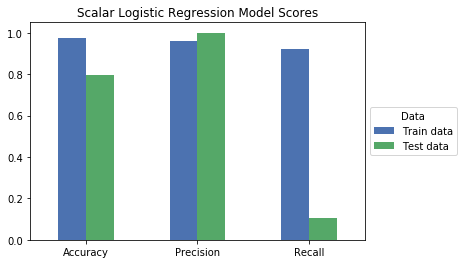

In [131]:
logregsc_metrics_dic = {'Metric': ['Acc', 'Prec', 'Recall'],
        'Train data': [logistic_reg_model_sc.score(X_train_sc, y_train),
                    metrics.precision_score(y_train, logistic_reg_model_sc.predict(X_train_sc)),
                    metrics.recall_score(y_train, logistic_reg_model_sc.predict(X_train_sc))],
        'Test data': [logistic_reg_model_sc.score(X_test_sc, y_test),
                    metrics.precision_score(y_test, logistic_reg_model_sc.predict(X_test_sc)),
                    metrics.recall_score(y_test, logistic_reg_model_sc.predict(X_test_sc))]}

logregsc_metrics = pd.DataFrame(data=logregsc_metrics_dic, 
                        columns=['Metric','Train data','Test data'])

fig, ax = plt.subplots()

logregsc_metrics.plot.bar(ax=ax)

ax.set_title('Scalar Logistic Regression Model Scores')
ax.set_xticklabels(['Accuracy', 'Precision', 'Recall'], rotation=0)
ax.legend(title='Data',loc='center left', bbox_to_anchor=(1, 0.5))

In [105]:
# Random Forest com scaler

In [106]:
#### Treinamos um classificador Random Forest com todas as features escalarizadas:

In [107]:
rand_for_model = RandomForestClassifier().fit(X_train_sc, y_train)

In [108]:
#### E os resultados do modelo foram:

In [109]:
print("Random Forest train acc: ", rand_for_model.score(X_train_sc, y_train))
print("Random Forest train prec: ", metrics.precision_score(y_train, rand_for_model.predict(X_train_sc)))
print("Random Forest train recall: ", metrics.recall_score(y_train, rand_for_model.predict(X_train_sc)))
print("")
print("Random Forest test acc: ", rand_for_model.score(X_test_sc, y_test))
print("Random Forest test prec: ", metrics.precision_score(y_test, rand_for_model.predict(X_test_sc)))
print("Random Forest test recall: ", metrics.recall_score(y_test, rand_for_model.predict(X_test_sc)))

Random Forest train acc:  1.0
Random Forest train prec:  1.0
Random Forest train recall:  1.0

Random Forest test acc:  0.9443430656934306
Random Forest test prec:  0.9563106796116505
Random Forest test recall:  0.7911646586345381


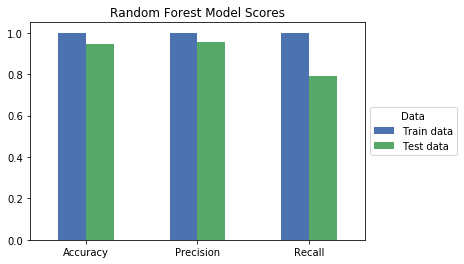

In [132]:
randomf_metrics_dic = {'Metric': ['Acc', 'Prec', 'Recall'],
        'Train data': [rand_for_model.score(X_train_sc, y_train),
                    metrics.precision_score(y_train, rand_for_model.predict(X_train_sc)),
                    metrics.recall_score(y_train, rand_for_model.predict(X_train_sc))],
        'Test data': [rand_for_model.score(X_test_sc, y_test),
                    metrics.precision_score(y_test, rand_for_model.predict(X_test_sc)),
                    metrics.recall_score(y_test, rand_for_model.predict(X_test_sc))]}

randomf_metrics = pd.DataFrame(data=randomf_metrics_dic, 
                        columns=['Metric','Train data','Test data'])

fig, ax = plt.subplots()

randomf_metrics.plot.bar(ax=ax)

ax.set_title('Random Forest Model Scores')
ax.set_xticklabels(['Accuracy', 'Precision', 'Recall'], rotation=0)
ax.legend(title='Data',loc='center left', bbox_to_anchor=(1, 0.5))

In [111]:
# Comparação entre os modelos com todas as features

In [112]:
#### Comparamos os resultados de todos os modelos treinados com todas as features:

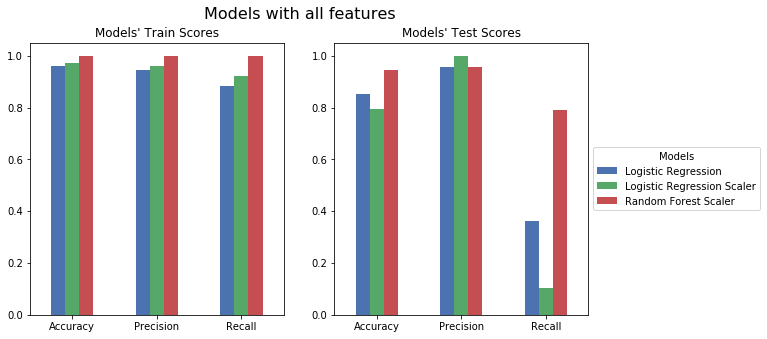

In [133]:
train_metrics_dic = {'Metric': ['Acc', 'Prec', 'Recall'],
        'Logistic Regression': [logistic_reg_model.score(X_train, y_train),
                                metrics.precision_score(y_train, logistic_reg_model.predict(X_train)),
                                metrics.recall_score(y_train, logistic_reg_model.predict(X_train))],
        'Logistic Regression Scaler': [logistic_reg_model_sc.score(X_train_sc, y_train),
                                        metrics.precision_score(y_train, logistic_reg_model_sc.predict(X_train_sc)),
                                        metrics.recall_score(y_train, logistic_reg_model_sc.predict(X_train_sc))],
        'Random Forest Scaler': [rand_for_model.score(X_train_sc, y_train), 
                                metrics.precision_score(y_train, rand_for_model.predict(X_train_sc)),
                                metrics.recall_score(y_train, rand_for_model.predict(X_train_sc))]}

test_metrics_dic = {'Metric': ['Acc', 'Prec', 'Recall'],
        'Logistic Regression': [logistic_reg_model.score(X_test, y_test),
                                metrics.precision_score(y_test, logistic_reg_model.predict(X_test)),
                                metrics.recall_score(y_test, logistic_reg_model.predict(X_test))],
        'Logistic Regression Scaler': [logistic_reg_model_sc.score(X_test_sc, y_test),
                                        metrics.precision_score(y_test, logistic_reg_model_sc.predict(X_test_sc)),
                                        metrics.recall_score(y_test, logistic_reg_model_sc.predict(X_test_sc))],
        'Random Forest Scaler': [rand_for_model.score(X_test_sc, y_test), 
                                metrics.precision_score(y_test, rand_for_model.predict(X_test_sc)),
                                metrics.recall_score(y_test, rand_for_model.predict(X_test_sc))]}

train_metrics = pd.DataFrame(data=train_metrics_dic, 
                            columns=['Metric','Logistic Regression','Logistic Regression Scaler','Random Forest Scaler'])

test_metrics = pd.DataFrame(data=test_metrics_dic, 
                            columns=['Metric','Logistic Regression','Logistic Regression Scaler','Random Forest Scaler'])


fig, ax = plt.subplots(1,2, figsize=(10,5))

fig.suptitle('Models with all features', fontsize=16)

train_metrics.plot.bar(ax=ax[0],legend=False)

ax[0].set_title('Models\' Train Scores')
ax[0].set_xticklabels(['Accuracy', 'Precision', 'Recall'], rotation=0)

test_metrics.plot.bar(ax=ax[1])

ax[1].set_title('Models\' Test Scores')
ax[1].set_xticklabels(['Accuracy', 'Precision', 'Recall'], rotation=0)
ax[1].legend(title='Models',loc='center left', bbox_to_anchor=(1, 0.5))

In [114]:
# Feature selection

In [115]:
#### Utilizamos a função SelectKBest para selecionar 10 features 

In [116]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [117]:
featselect = SelectKBest(chi2, k=10).fit(X_train, y_train)
X_train_selected = featselect.transform(X_train)
X_test_selected = featselect.transform(X_test)

In [118]:
mask = featselect.get_support() #list of booleans
new_features = [] # The list of your K best features

for bool, feature in zip(mask, list(X_train.columns)):
    if bool:
        new_features.append(feature)

In [119]:
new_features

['num_mentions',
 'is_reply',
 'http',
 'follow',
 'guy',
 'video',
 'check',
 'twitter',
 'para',
 'cute']

In [120]:
#### As features selecionadas foram a média de menções de cada usuário (num_mentions), a média de tweets que são respostas a outros tweets (is_reply), a média de links nos tweets e também a média de tweets que contém as palavras 'follow', 'guy', 'video', 'check', 'twitter', 'para' e 'cute'

In [121]:
#### Treinamos um classificador Random Forest com essas features que foram selecionadas:

In [122]:
rand_for_model_new = RandomForestClassifier().fit(X_train_selected, y_train)

In [123]:
#### E os resultados do modelo foram:

In [124]:
print("Random Forest 10 features train acc: ", rand_for_model_new.score(X_train_selected, y_train))
print("Random Forest 10 features train prec: ", metrics.precision_score(y_train, rand_for_model_new.predict(X_train_selected)))
print("Random Forest 10 features train recall: ", metrics.recall_score(y_train, rand_for_model_new.predict(X_train_selected)))
print("")
print("Random Forest 10 features test acc: ", rand_for_model_new.score(X_test_selected, y_test))
print("Random Forest 10 features test prec: ", metrics.precision_score(y_test, rand_for_model_new.predict(X_test_selected)))
print("Random Forest 10 features test recall: ", metrics.recall_score(y_test, rand_for_model_new.predict(X_test_selected)))

Random Forest 10 features train acc:  1.0
Random Forest 10 features train prec:  1.0
Random Forest 10 features train recall:  1.0

Random Forest 10 features test acc:  0.947992700729927
Random Forest 10 features test prec:  0.98
Random Forest 10 features test recall:  0.7871485943775101


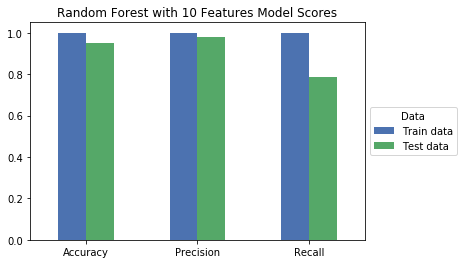

In [134]:
randomf_10_metrics_dic = {'Metric': ['Acc', 'Prec', 'Recall'],
        'Train data': [rand_for_model_new.score(X_train_selected, y_train),
                    metrics.precision_score(y_train, rand_for_model_new.predict(X_train_selected)),
                    metrics.recall_score(y_train, rand_for_model_new.predict(X_train_selected))],
        'Test data': [rand_for_model_new.score(X_test_selected, y_test),
                    metrics.precision_score(y_test, rand_for_model_new.predict(X_test_selected)),
                    metrics.recall_score(y_test, rand_for_model_new.predict(X_test_selected))]}

randomf_10_metrics = pd.DataFrame(data=randomf_10_metrics_dic, 
                        columns=['Metric','Train data','Test data'])

fig, ax = plt.subplots()

randomf_10_metrics.plot.bar(ax=ax)

ax.set_title('Random Forest with 10 Features Model Scores')
ax.set_xticklabels(['Accuracy', 'Precision', 'Recall'], rotation=0)
ax.legend(title='Data',loc='center left', bbox_to_anchor=(1, 0.5))

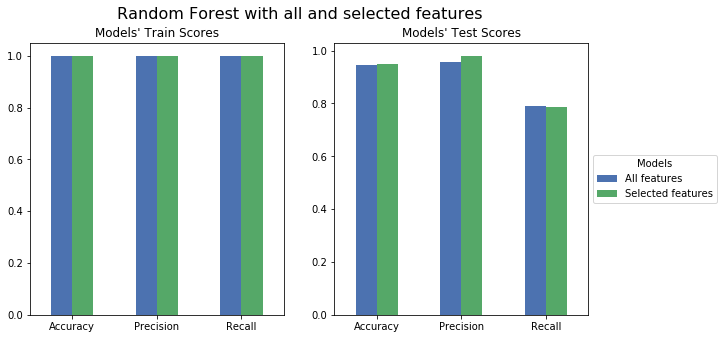

In [135]:
rf_train_metrics_dic = {'Metric': ['Acc', 'Prec', 'Recall'],
        'All features': [rand_for_model.score(X_train_sc, y_train),
                    metrics.precision_score(y_train, rand_for_model.predict(X_train_sc)),
                    metrics.recall_score(y_train, rand_for_model.predict(X_train_sc))],
        'Selected features': [rand_for_model_new.score(X_train_selected, y_train),
                    metrics.precision_score(y_train, rand_for_model_new.predict(X_train_selected)),
                    metrics.recall_score(y_train, rand_for_model_new.predict(X_train_selected))]}

rf_test_metrics_dic = {'Metric': ['Acc', 'Prec', 'Recall'],
        'All features': [rand_for_model.score(X_test_sc, y_test),
                    metrics.precision_score(y_test, rand_for_model.predict(X_test_sc)),
                    metrics.recall_score(y_test, rand_for_model.predict(X_test_sc))],
        'Selected features': [rand_for_model_new.score(X_test_selected, y_test),
                    metrics.precision_score(y_test, rand_for_model_new.predict(X_test_selected)),
                    metrics.recall_score(y_test, rand_for_model_new.predict(X_test_selected))]}

rf_train_metrics = pd.DataFrame(data=rf_train_metrics_dic, 
                            columns=['Metric','All features','Selected features'])

rf_test_metrics = pd.DataFrame(data=rf_test_metrics_dic, 
                            columns=['Metric','All features','Selected features'])


fig, ax = plt.subplots(1,2, figsize=(10,5))

fig.suptitle('Random Forest with all and selected features', fontsize=16)

rf_train_metrics.plot.bar(ax=ax[0],legend=False)

ax[0].set_title('Models\' Train Scores')
ax[0].set_xticklabels(['Accuracy', 'Precision', 'Recall'], rotation=0)

rf_test_metrics.plot.bar(ax=ax[1])

ax[1].set_title('Models\' Test Scores')
ax[1].set_xticklabels(['Accuracy', 'Precision', 'Recall'], rotation=0)
ax[1].legend(title='Models',loc='center left', bbox_to_anchor=(1, 0.5))